# Formatting the GIS census region data

This notebook accomplishes the following:
* Generates a filtered version of the census file
* Plots the gis data for visualization
* Develop the reverse geoencoder function to look up addresses using lat lon coordinates


*Author: Koki Sasagawa*  
*Last Edited: 3/20/19*

# SF 2010 census tracts data
[dataset link](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Census-2010-Tracts-for-San-Francisco/rarb-5ahf)

`shp` - file containing geometry of each feature  
`dbf` - dBase file containing attribute data for all of the features in the dataset  
`shx` - spatial index, allows GIS systems to find features within the shp files  
`prj` - projection file containing information about the projection and coordinate system the data uses


| Code        | Description |
|:------------|:------------|
| aland10     | Area(land)  |
| awater10    | Area(Water) |
| countryfp10 | County FIPS |
| funcstat10  | Functional Status Code (e.g., S = Statistical Entity) |
| geoid10     | Numeric codes that uniquely identify all administrative/legal and statistical geographic areas |
| intptlat10  | Internal Point (Latitude) |
| intptlon10  | Internal Point (Longitude) |
| mtfcc10     | MAF/TiGER feature class code |
| namelsad    | Current name and the translated lega/statistical area dscription |
| statefp10   | state FIPS |
| tractce10   | census tract |
| geometry    | shape on earth as specified by lat and lon |

`FIPS`- Federal Information Processing Series: numeric codes assigned by the National Institude of Standards and Technology (NIST). Deals with US states and counties. US states identified with a 2-digit number while US counties are idnentified by a 3-digit number. 
> Example:
> FIPS code: 06071 represents
> California - 06
> San Bernardino County - 071

In [1]:
import geopandas as gpd
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import os
import requests
import urllib
import json 

%matplotlib inline

In [2]:
# Specifiy directory containing shape file
gis_data_dir = '../../raw_data/census_zones/sf/'

files = os.listdir(gis_data_dir)
for i, n in enumerate(files):
    print(i,n)

0 temp
1 .DS_Store
2 geo_export_8c14e8b6-2d3c-4109-af6b-f6e25cb69f0c.prj
3 san_francisco_censustracts.json
4 geo_export_8c14e8b6-2d3c-4109-af6b-f6e25cb69f0c.dbf
5 geo_export_8c14e8b6-2d3c-4109-af6b-f6e25cb69f0c.shp
6 geo_export_8c14e8b6-2d3c-4109-af6b-f6e25cb69f0c.shx


In [3]:
sf_census_zones = gpd.GeoDataFrame.from_file(gis_data_dir + files[5])
print('Size of census zones df: {}'.format(sf_census_zones.shape))
sf_census_zones.head()

Size of census zones df: (197, 13)


,aland10,awater10,countyfp10,funcstat10,geoid10,intptlat10,intptlon10,mtfcc10,name10,namelsad10,statefp10,tractce10,geometry
0,370459.0,0.0,075,S,06075016500,+37.7741958,-122.4477884,G5020,165,Census Tract 165,06,016500,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,309097.0,0.0,075,S,06075016400,+37.7750995,-122.4369729,G5020,164,Census Tract 164,06,016400,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,245867.0,0.0,075,S,06075016300,+37.7760456,-122.4295509,G5020,163,Census Tract 163,06,016300,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,368901.0,0.0,075,S,06075016100,+37.7799831,-122.4286631,G5020,161,Census Tract 161,06,016100,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,158236.0,0.0,075,S,06075016000,+37.7823363,-122.4224838,G5020,160,Census Tract 160,06,016000,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


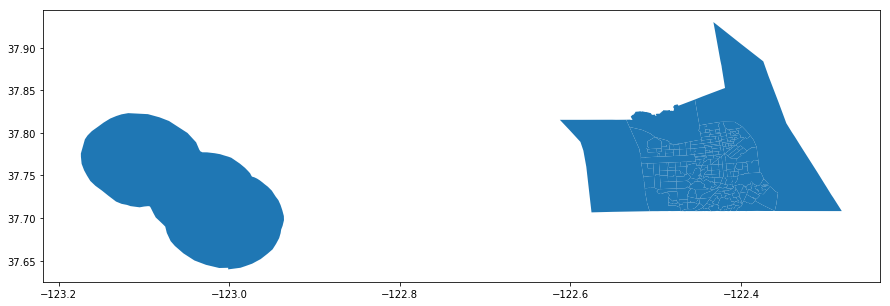

In [4]:
sf_census_zones.plot(figsize=(15, 15))

## Change lat, lon columns into float type to enable comparison operator

In [5]:
sf_census_zones.intptlon10 = sf_census_zones.intptlon10.astype(float)
sf_census_zones.intptlat10 = sf_census_zones.intptlat10.astype(float)
sf_census_zones.geoid10 = sf_census_zones.geoid10.astype(int)

In [6]:
sf_census_zones.dtypes

aland10       float64
awater10      float64
countyfp10     object
funcstat10     object
geoid10         int64
intptlat10    float64
intptlon10    float64
mtfcc10        object
name10         object
namelsad10     object
statefp10      object
tractce10      object
geometry       object
dtype: object

## Remove the Middle Farallon Island from census zone

In [7]:
# Farallon Island
sf_census_zones[sf_census_zones['intptlon10'] < -122.9]['geoid10']

41    6075980401
Name: geoid10, dtype: int64

In [8]:
sf_census_zones = sf_census_zones[sf_census_zones['intptlon10'] > -122.9]
sf_census_zones.reset_index(inplace=True, drop=True)
print(sf_census_zones.shape)
sf_census_zones.head()

(196, 13)


,aland10,awater10,countyfp10,funcstat10,geoid10,intptlat10,intptlon10,mtfcc10,name10,namelsad10,statefp10,tractce10,geometry
0,370459.0,0.0,075,S,6075016500,37.774196,-122.447788,G5020,165,Census Tract 165,06,016500,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,309097.0,0.0,075,S,6075016400,37.775100,-122.436973,G5020,164,Census Tract 164,06,016400,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,245867.0,0.0,075,S,6075016300,37.776046,-122.429551,G5020,163,Census Tract 163,06,016300,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,368901.0,0.0,075,S,6075016100,37.779983,-122.428663,G5020,161,Census Tract 161,06,016100,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,158236.0,0.0,075,S,6075016000,37.782336,-122.422484,G5020,160,Census Tract 160,06,016000,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


In [9]:
# Save filtered census file in temp folder
sf_census_zones.to_file('../../temp_data/sf_filtered_census_data.shp')

/Users/koki/Documents/Learning/UMICH_Courses/SI_699_Big_Data/rushhour_2/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Generate a file containing only the geoid and GIS polygon for each census zones

In [11]:
relevant_col = sf_census_zones.columns[[4, 12]].to_list()
sf_census_zones[relevant_col].to_file('../../temp_data/sf_GEOID_GIS_data.shp')

/Users/koki/Documents/Learning/UMICH_Courses/SI_699_Big_Data/rushhour_2/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


# Color to census map 

color polygon corresponding to geoid10=6075010900

In [10]:
# Get all unique geoid's
geoid = sf_census_zones['geoid10']
print(geoid.shape)
geoid.head()

(196,)


0    6075016500
1    6075016400
2    6075016300
3    6075016100
4    6075016000
Name: geoid10, dtype: int64

In [11]:
# Create arbitrary series of size N
color_val = pd.Series([0] * 196, name='color_val')
print(color_val.shape)
color_val.head()

(196,)


0    0
1    0
2    0
3    0
4    0
Name: color_val, dtype: int64

In [12]:
color_df = pd.concat([geoid, color_val], axis=1, ignore_index=False)
color_df['geoid10'] = color_df['geoid10'].astype(int)
print(color_df.shape)
color_df.head()

(196, 2)


,geoid10,color_val
0,6075016500,0
1,6075016400,0
2,6075016300,0
3,6075016100,0
4,6075016000,0


In [13]:
# Change the color val or row where geoid corresponds to 6075010900 
color_df.loc[color_df['geoid10'] == 6075010900, 'color_val'] = 1
# color_df.to_csv('../../temp_data/test1.csv')

In [14]:
sf_census_zones = sf_census_zones.merge(color_df, on='geoid10')
print(sf_census_zones.shape)
sf_census_zones.head()

(196, 14)


,aland10,awater10,countyfp10,funcstat10,geoid10,intptlat10,intptlon10,mtfcc10,name10,namelsad10,statefp10,tractce10,geometry,color_val
0,370459.0,0.0,075,S,6075016500,37.774196,-122.447788,G5020,165,Census Tract 165,06,016500,"POLYGON ((-122.446471 37.775802, -122.44478 37...",0
1,309097.0,0.0,075,S,6075016400,37.775100,-122.436973,G5020,164,Census Tract 164,06,016400,"POLYGON ((-122.44034 37.77658, -122.439844 37....",0
2,245867.0,0.0,075,S,6075016300,37.776046,-122.429551,G5020,163,Census Tract 163,06,016300,"POLYGON ((-122.429152 37.778007, -122.428909 3...",0
3,368901.0,0.0,075,S,6075016100,37.779983,-122.428663,G5020,161,Census Tract 161,06,016100,"POLYGON ((-122.428909 37.778039, -122.429152 3...",0
4,158236.0,0.0,075,S,6075016000,37.782336,-122.422484,G5020,160,Census Tract 160,06,016000,"POLYGON ((-122.420425 37.780583, -122.420336 3...",0


# Reverse geocode coordinates to address

[Reverse geocode API documentation](https://developer.here.com/api-explorer/rest/geocoder/reverse-geocode)

In [15]:
def reverse_geocode(lat, lon):
    """Reverse geocode lat and lon coordiantes to address using the Geocoder API
    
    :param float lat: latitude coordinate
    :param flaot lon: longitude coordinate
    """
    
    #Encode parameters
    coordinates = str(lat) + ',' + str(lon)
    params = urllib.parse.urlencode({'prox': coordinates,
                                     'mode': 'retrieveAddresses',
                                     'maxresults': 1,
                                     'gen': 9,
                                     'app_id': 'ovri1bLuIbAuqStQ2uGd',
                                     'app_code': 'rjjPMI8lkbKunwo1d65PCw',
                                     })
    
    #Contruct request URL
    # url = 'https://geo.fcc.gov/api/census/area?' + params
    url = 'https://reverse.geocoder.api.here.com/6.2/reversegeocode.json?' + params
    
    #Get response from API
    response = requests.get(url)

    #Parse json in response
    data = response.json()

    #Print FIPS code
    return data
#     return data['County']['FIPS']

In [16]:
reverse_geocode(37.80456, -122.41509)

{'Response': {'MetaInfo': {'Timestamp': '2019-03-21T02:07:59.165+0000'},
  'View': [{'_type': 'SearchResultsViewType',
    'ViewId': 0,
    'Result': [{'Relevance': 1.0,
      'Distance': 0.3,
      'MatchLevel': 'street',
      'MatchQuality': {'Country': 1.0,
       'State': 1.0,
       'County': 1.0,
       'City': 1.0,
       'District': 1.0,
       'Street': [1.0],
       'PostalCode': 1.0},
      'Location': {'LocationId': 'NT_VPVp4nGqIL-xK1E3SmZZlD_l_23618668_L',
       'LocationType': 'address',
       'DisplayPosition': {'Latitude': 37.8045607, 'Longitude': -122.4150861},
       'NavigationPosition': [{'Latitude': 37.8045607,
         'Longitude': -122.4150861}],
       'MapView': {'TopLeft': {'Latitude': 37.8052, 'Longitude': -122.4152},
        'BottomRight': {'Latitude': 37.80447, 'Longitude': -122.41507}},
       'Address': {'Label': 'Taylor St, San Francisco, CA 94133, United States',
        'Country': 'USA',
        'State': 'CA',
        'County': 'San Francisco',
    

In [17]:
address = reverse_geocode(37.80456, -122.41509)["Response"]["View"][0]["Result"][0]["Location"]["Address"]['Label']

In [18]:
address

'Taylor St, San Francisco, CA 94133, United States'

# Plot

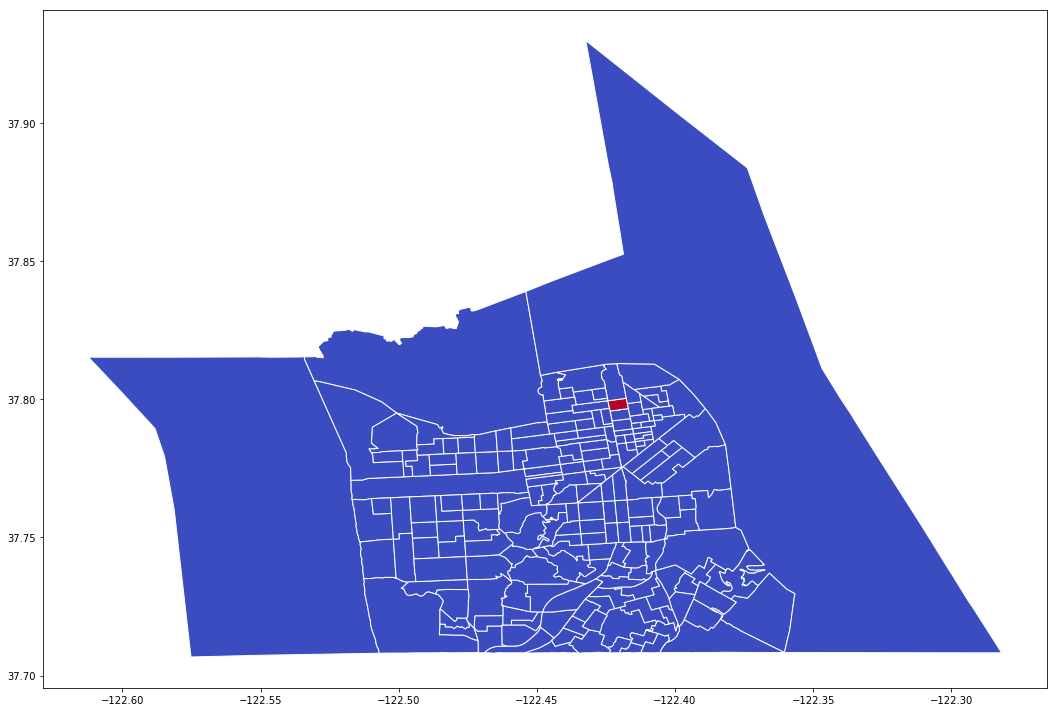

In [19]:
# plot the shapefile/GeoDataFrame
# Set coordinate reference system
sf_census_zones.crs = {'init': 'epsg:4326'}
g = sf_census_zones.plot(column='color_val', vmin=0, vmax=1, cmap='coolwarm', edgecolor='white', figsize=(18, 18))

# Get lat - lon coordinate for point of interest 
# lat, lon = sf_census_zones[sf_census_zones.geoid10 == 6075010900][['intptlat10', 'intptlon10']].values[0]
# g.annotate(s='{}, {}, {}'.format(lat, lon, address), xy=(lat, lon))

plt.savefig('../../output/High_traffic_zone.png')